# Part a
This notebook contains a step-by-step walkthrough of task a) using both code and text.

In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src/')

### Loading the data and constructing the design matrix
For simplicity one function is used to load the data and create the design matrix. Degree 4 is choosen for the polynomial design matrix and will be used in further analyses.

In [8]:
from data.create_dataset import create_dataset
X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=4) 

### Splitting and plotting the data

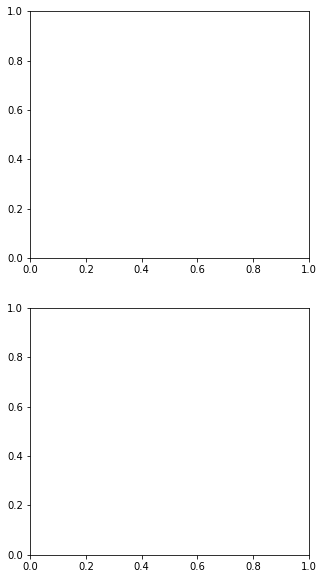

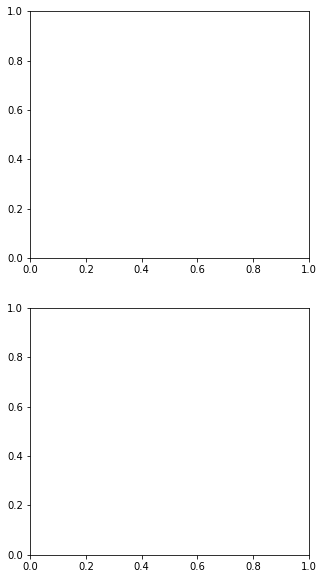

In [55]:
from visualization.visualize import plot_surf_from_X
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt

X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(5,10))
#gs = fig.add_gridspec(2,2)
#sub1 =fig.add_subfigure(gs[0,0])
#sub2 = plot_surf_from_X(X,z)
#sub2.set_figure(fig) 
#plot_surf_from_X(X_train,z_train)
ax1 = plot_surf_from_X(X_test,z_test)
fig

matplotlib.figure.Figure